In [8]:
# Importing dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [7]:
# Define the model parameters
def default_params(**kwargs):
    params = {}

    # Define neuron parameters
    params['tau_m'] = 50.0 # Membrane time constant
    params['g_L'] = 1e-6  # Leak resistance (in ohms)
    params['E_L'] = 0.0  # Resting potential (in mV)
    params['V_th'] = 20.0  # Threshold voltage (in mV)
    params['V_reset'] = 0.0  # Reset voltage (in mV)
    params['V_init'] = -70.0   # initial potential [mV]
    params['t_ref'] = 2.0  # Refractory period (in ms)

    # Define the simulation parameters
    params['dt'] = 0.1  # Time step (in ms)
    params['T'] = 1000.0  # Simulation duration (in ms)

    params['range_t'] = np.arange(0, params['T'], params['dt'])  # Vector of discretized time points [ms]

    # external parameters if any 
    for k in kwargs:
        params[k] = kwargs[k]

    return params

In [6]:
def generate_poisson_spikes(params, rate, user_seed=False):
    """
    Generate poisson spike trains

    Args:
    params      :   Parameters dictionary
    rate        :   Poisson noise amplitude (Hz)
    user_seed   :   Random seed. int or boolean
    """
    # get simulation parameters
    dt, T = params['dt'], params['T'] 
    n = int(T / dt) # Number of spike trains
    
    # set random seed
    if user_seed:
        np.random.seed(seed=user_seed)
    else:
        np.random.seed()
    
    # generate poisson spike trains
    I_pos = np.random.poisson(rate * (dt/1000.), size=n)
    
    # find spike times
    #spike_times = np.where(I_pos > 0)[0] * dt
    
    return I_pos

In [5]:
# Synaptic current waveform
def synaptic_current(I0, tau_syn, t):
    return I0 * np.sum(np.exp(-t/tau_syn))

In [2]:
def run_synaptic_LIF(params, I_ext):
    """
    Simulate the LIF dynamics with external input current

    Args:
        params     : parameter dictionary
        I_ext      : external input current [mA]. The injected current here can be a value or an array

    Returns:
        rec_spikes     : spike times
    """
 
    # Set parameters
    V_th, V_reset = params['V_th'], params['V_reset']
    tau_m, g_L = params['tau_m'], params['g_L']
    I0 = params['I0']
    tau_syn = params['tau_syn']
    V_init, E_L = params['V_init'], params['E_L']
    dt, T, range_t = params['dt'], params['T'], params['range_t']
    t_ref = params['t_ref']
    Lt = range_t.size
    
    # Initialize voltage and current
    v = np.zeros(Lt)
    v[0] = V_init
    I_ext = I_ext * np.ones(Lt)
    I_syn = np.zeros_like(I_ext)
    tr = 0. # the count for refractory duration

    rec_spikes = [] # record spike times
    ISIs = [] # record inter-spike intervals

    # Simulate synaptic LIF dynamics
    for it in range(Lt - 1):

        # compute synaptic current
        if len(rec_spikes) > 0:
            t = (it*dt - rec_spikes)
            I_syn = synaptic_current(I0, tau_syn, t)
        else:
            I_syn = 0
        
        # Compute total input current
        I_total = np.convolve(I_syn, I_ext[it], mode='same')
        I_total *= dt / 1e-9 # convert to nA

        if tr > 0: # check if in refractory period
            v[it] = V_reset # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period
        
        elif v[it] >= V_th: # if voltage is over threshold
            rec_spikes.append(it*dt)
            # record inter-spike intervals
            ISIs.append(rec_spikes[-1] - rec_spikes[-2]) if len(rec_spikes) > 1 else None
            v[it] = V_reset # reset voltage
            tr = t_ref / dt # set refractory time
        
        # Calculate increment of membrane potential
        dv = (-(v[it] - E_L) + I_total / g_L) * (dt / tau_m)

        # update the membrane potential
        v[it+1] = v[it] + dv

        # get spikes in ms
        rec_spikes = np.array(rec_spikes)
        # compute firing rate
        num_spikes = len(rec_spikes)
        duration = Lt * dt
        firing_rate =  num_spikes / duration * 1000

    return rec_spikes

In [9]:
def isi_cv_LIF(spike_times):
  """
  Calculates the inter-spike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train
  Args:
    spike_times : (n, ) vector with the spike times (ndarray)
  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)
  """
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = isi.std()/isi.mean()  
  else:
    isi = np.nan
    cv = np.nan
  
  return isi, cv

In [11]:
params = default_params()
# Add parameters
params['tau_syn'] = 5.  # [ms]
params['I0'] = 20.

In [12]:
# Generate poisson spike trains
rate1 = 500 # poisson rate (Hz)
rate2 = 300
I_pos1 = generate_poisson_spikes(params, rate=rate1, user_seed=False)
I_pos2 = generate_poisson_spikes(params, rate=rate2, user_seed=False)

Text(0, 0.5, '$I_{pos}$ (nA)')

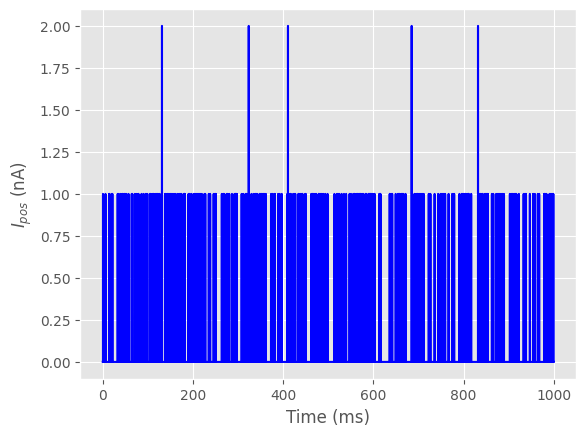

In [13]:
# Plot input spikes
plt.plot(params['range_t'], I_pos2, 'blue')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{pos}$ (nA)')

In [14]:
sp1 = run_synaptic_LIF(params, I_pos1)
sp2 = run_synaptic_LIF(params, I_pos2)

In [22]:
rates = np.arange(1, 500, 10)  # stimulus rates in Hz

# Calculate CVs for each stimulus rate
cv_list = []
for rate in rates:
    I_pos = generate_poisson_spikes(params, rate)
    cv_list.append(run_synaptic_LIF(params, I_pos))

Text(0.5, 1.0, 'CV of interspike intervals')

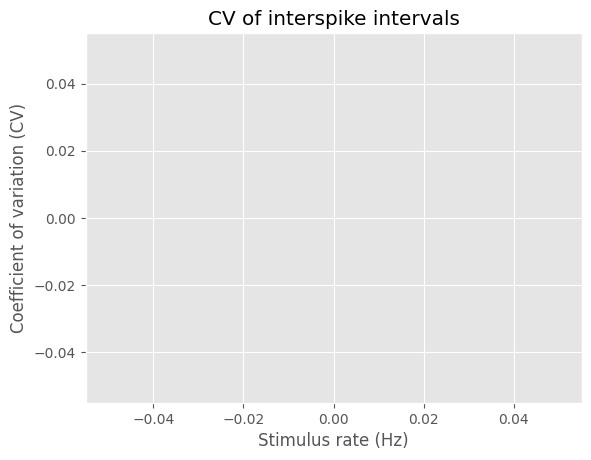

In [24]:
# Plot results
fig, ax = plt.subplots()
ax.plot(rates, cv_list, 'o-')
ax.set_xlabel('Stimulus rate (Hz)')
ax.set_ylabel('Coefficient of variation (CV)')
ax.set_title('CV of interspike intervals')